# Focal Multilabel Loss in Pytorch Explained

Top solutions in the previous HPA competition used focal loss. I'd like to understand this loss function better and this notebook helped me, hoping it can be helpful for others too! Please upvote if it is :) 

The [original paper](https://arxiv.org/pdf/1708.02002.pdf) defines focal loss in multiclass classification scenario which is different from multilabel that we're dealing with in this competition. Here's a visual with high level summary copied from [Papers with Code](https://paperswithcode.com/method/focal-loss). The main promise is that this will help us deal with imbalanced datasets by focusing on hard-to-predict classes.

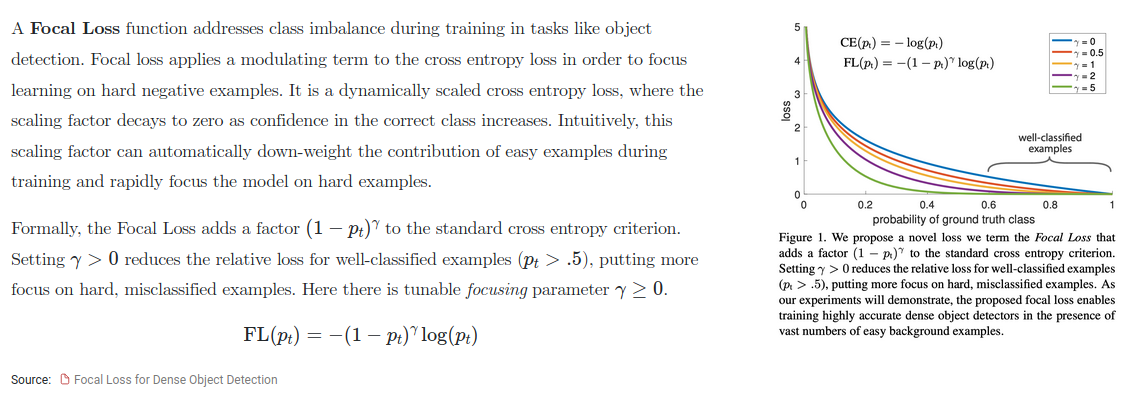

The loss function code is coming from @hengck23 script shared in [this thread](https://www.kaggle.com/c/hpa-single-cell-image-classification/discussion/217238). Let's take it apart!

In [ ]:
import torch
torch.set_printoptions(precision=4, sci_mode=False, linewidth=150)

def focal_binary_cross_entropy(logits, targets, gamma=2):
    l = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.sigmoid(l)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = num_label*loss.mean()
    return loss

Logits come directly from the model output - let's use a range of possible values. For each logit value, let's have both 0 an 1 targets. We'll work with batch size = 1 and 8 classes. 

In [ ]:
num_label = 8
logits = torch.tensor([[-5., -5, 0.1, 0.1, 5, 5, 100, 100]])
targets = torch.tensor([[0, 1, 0, 1, 0, 1, 0, 1]])
logits.shape, targets.shape

The first thing that happens is flattening of logits and targets so that we can compare two vectors (rank-1 tensors). 

In [ ]:
l = logits.reshape(-1)
t = targets.reshape(-1)
l.shape, t.shape

Next, we apply sigmoid to the logits to squeeze the values between 0 and 1. 

In [ ]:
p = torch.sigmoid(l)
p

We are following now the standard binary cross entropy with logits loss. For positive examples, we'll take the sigmoid, for negative examples, we'll take 1-sigmoid. Good predictions will be close to 1, bad predictions will be close to 0. 

In [ ]:
p = torch.where(t >= 0.5, p, 1-p)
p

The additional thing that happens here is clamping the input to avoid being to close to zero or one. This is probably for numeric stability. 

In [ ]:
clamp_p = torch.clamp(p, 1e-4, 1-1e-4)
clamp_p

Now we apply negative log - this is the BCE loss. This will convert good predictions to a loss that is close to 0, and bad predictions will go to infinity.

In [ ]:
logp = - torch.log(clamp_p)
logp

Now finally the focal loss magic: `loss = logp*((1-p)**gamma)`. Let's take it apart to really understand what happens. Our default for gamma is `2`. 

In [ ]:
gamma = 2
print(f'logp: {logp}')
print(f'p: {p}')
print(f'1-p: {1-p}')
x = (1-p)**gamma
print(f'(1-p)**gamma: {x}')
loss = logp*((1-p)**gamma)
print(f'logp*((1-p)**gamma):{loss}')

So what happened here?
1. logp is the classic BCE loss
2. p is close to 1 for good predictions, close to 0 for bad predictions
3. 1-p is the opposite: close to 0 for good predictions, close to 1 for bad predictions
4. With gamma=2 we square (1-p): the better the predictions, the closer to zero we will take them
5. We multiply this with the original BCE loss

The outcome: 
- for good predictions, the loss is much smaller than it was, getting close to zero
- for bad predictions, the loss is not changed much

This will force the model to learn more from bad predictions, while the good predictions will have limited impact on the parameters.

Finally, we need to revert the flattening than we've done at the beginning. We'll simply take the mean of all loss values and multiply it by the number of labels. 

In [ ]:
loss = num_label*loss.mean()
loss

Based on @dschettler8845 comment I tried to reproduce the same in tensorflow - I think the snippet below gets "close enough", the key difference is that I omitted alpha in the implementation above (in Pytorch, alpha can be handled by weights). 

In [ ]:
import tensorflow_addons as tfa
import tensorflow as tf
fl = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True, alpha=0.5)
tlogits = tf.constant([[-5.], [-5], [0.1], [0.1], [5],[5], [100], [100]], dtype=tf.float32)
ttargets = tf.constant([[0], [1], [0], [1], [0], [1], [0], [1]], dtype=tf.float32)
fl(ttargets, tlogits) * 2